# Bagging, Boosting n Stacking


### Marco Túlio S. da Mata 20193007156 - DECOM LIC Prof. Rogério - CEFET_MG


## <span style="color:green">*1. Boosting and Stacking Exercises*</span>

## Introduction

We will be using the customer churn data from the telecom industry for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

In [2]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data from the file `Orange_Telecom_Churn_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determine if the float columns need to be scaled.

In [4]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data has quite a few predictor columns.

In [5]:
data.shape

(5000, 21)

In [6]:
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account_length,128,107,137,84,75
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
intl_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34


In [7]:
data.drop(['state', 'phone_number', 'area_code'], axis=1, inplace=True)

In [8]:
data.dtypes.value_counts()

float64    8
int64      7
object     2
bool       1
dtype: int64

A: Note that not all column values ​​are floats. There is a boolean, but this is the result we want to obtain, so with the exception of the result column, we will have to transform the object values ​​into float.

In [9]:
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes',0).replace('no',1).astype(float)
    
    
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          float64
voice_mail_plan    float64
dtype: object

In [10]:
data.dtypes.value_counts()

float64    10
int64       7
bool        1
dtype: int64

## Question 2

* Integer encode the activities.
* Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [11]:
# Data are skewed at ~85% towards non-churned customers
# This will be important to remember when model building

data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [12]:
data.churned.value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['churned'] = le.fit_transform(data['churned'])

le.classes_

array([False,  True])

In [14]:
data.churned.unique()

array([0, 1], dtype=int64)

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [15]:
from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'churned']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['churned'],
                 test_size=0.3, random_state=42)


In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3500, 17), (3500,), (1500, 17), (1500,))

## Question 3

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 3 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)

    # Fit the model
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

c:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
c:\Users\Mark\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted

,error
n_trees,
15.0,0.098000
50.0,0.058667
100.0,0.050000
200.0,0.046667
400.0,0.046667


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib inline

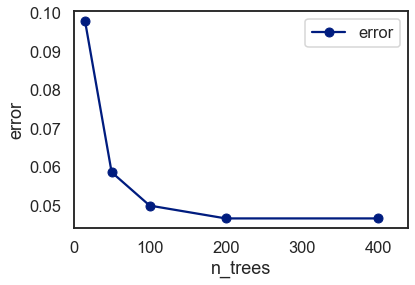

In [19]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

## Question 4

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 3. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [20]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400],
              'learning_rate': [0.1, 0.01]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=4,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [21]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=200, random_state=42,
                           subsample=0.5)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [22]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1335
           1       0.73      0.92      0.81       165

    accuracy                           0.95      1500
   macro avg       0.86      0.94      0.89      1500
weighted avg       0.96      0.95      0.96      1500

   accuracy  precision    recall        f1       auc
0  0.953333   0.915152  0.729469  0.811828  0.859321


The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between churned class 1 and 2.

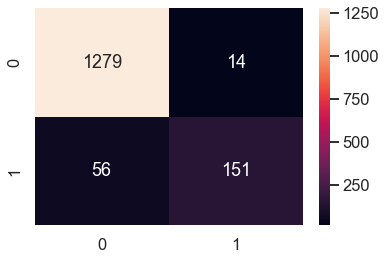

In [23]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 5

* Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [25]:
# best:
GV_ABC.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_features=4),
                   learning_rate=0.001, n_estimators=100)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic and now include class 0. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [26]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1268
           1       0.65      0.58      0.61       232

    accuracy                           0.89      1500
   macro avg       0.79      0.76      0.77      1500
weighted avg       0.88      0.89      0.88      1500

   accuracy  precision    recall        f1       auc
0     0.886   0.577586  0.647343  0.610478  0.785775


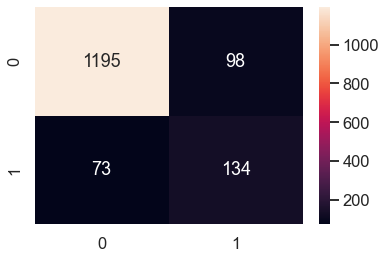

In [27]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 6

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [28]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, max_iter=10000, penalty='l2').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.

In [29]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1463
           1       0.13      0.73      0.22        37

    accuracy                           0.87      1500
   macro avg       0.56      0.80      0.58      1500
weighted avg       0.97      0.87      0.91      1500

   accuracy  precision    recall        f1      auc
0  0.873333    0.72973  0.130435  0.221311  0.56135


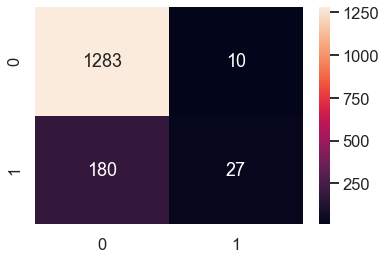

In [30]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [31]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [32]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1293
           1       0.94      0.47      0.63       207

    accuracy                           0.92      1500
   macro avg       0.93      0.73      0.79      1500
weighted avg       0.92      0.92      0.91      1500

   accuracy  precision   recall        f1       auc
0  0.923333   0.942308  0.47343  0.630225  0.734395


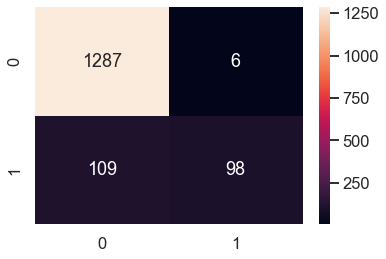

In [33]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')


## <span style="color:red">*Analysis:*</span>

- It is observed that the GradientBooster error did not completely stabilize with the generated trees; however, the error value consistently remained below 0.05 after 100 trees, reaching 0.04 with 400 trees. Using GridSearch with the GradientBooster, a model trained with 200 samples yielded satisfactory results, achieving an overall accuracy of 95%. However, upon examining the confusion matrix, it becomes evident that identifying true positive values (True) remains challenging

- In contrast, GridSearch with AdaBoost showed its best performance with a model using 100 samples. Despite this, its performance was inferior to the GradientBooster model, achieving an accuracy of 87%. Moreover, identifying true positive values (True) proved even more difficult, suggesting that the model struggled to generalize the data effectively. Similarly, the model using L1_L2 logistic regression demonstrated results comparable to AdaBoost, with an accuracy of 86%. The confusion matrix revealed similar challenges in correctly identifying true positives

- When stacking the L1_L2 model with the GradientBooster, the results were close to those of the GridSearch with GradientBooster. Although the stacked model did not outperform the standalone GradientBooster, it delivered satisfactory results, achieving an accuracy of 92%. The confusion matrix for the stacked model showed a performance akin to the GradientBooster from GridSearch, with challenges in identifying true positives. Nevertheless, compared to L1_L2 and AdaBoost, the stacked model showed a considerable improvement

- Finally, when comparing the best models from each approach—RandomForest for Bagging and GridSearch with GradientBooster for Boosting—it is clear that the Boosting model delivered a more competitive result. With an accuracy of 95%, compared to Bagging's 93%, the Boosting model also exhibited less difficulty in identifying true positives. This indicates that the Boosting approach might have been better at generalizing the data

## <span style="color:green">*2. Bagging Exercises*</span>

## Introduction

We will be using the customer churn data from the telecom industry for this week's exercises. The data file is called `Orange_Telecom_Churn_Data.csv`. 

Rotatividade de clientes

In [34]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the customer churn data, which is found in the file `Orange_Telecom_Churn_Data.csv`. 
* Remove any columns that are likely not to be used for prediction.
* Encode data types as appropriate.

In [35]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [36]:
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account_length,128,107,137,84,75
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
intl_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34


The prediction should definitely not include phone number. And it is unlikely that area code or state would be desired, unless there is some reason to assume the model has a very specific geographic factor.

In [37]:
data.drop(['state', 'phone_number', 'area_code'], axis=1, inplace=True)

Examine the data types. Everything looks OK other than `int_plan` and `voice_mail_plan` need to be boolean encoded.

In [38]:
data.dtypes

account_length                     int64
intl_plan                         object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                             bool
dtype: object

In [39]:
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes','True').replace('no','False').astype(bool)
    
    
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

## Question 2

* Examine distribution of the predicted variable (`churned`).
* Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
* Examine the distribution of the predictor variable in the train and test data.

In [40]:
# Data are skewed at ~85% towards non-churned customers
# This will be important to remember when model building

data.churned.value_counts()

False    4293
True      707
Name: churned, dtype: int64

In [41]:
data.churned.value_counts(normalize=True)

False    0.8586
True     0.1414
Name: churned, dtype: float64

Given the skew in the predictor variable, let's split the data with the *churned* values being stratified.

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit


feature_cols = [x for x in data.columns if x != 'churned']


# Split the data into two parts with 1500 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['churned']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'churned']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'churned']

In [43]:
y_train.value_counts(normalize=True)

False    0.858571
True     0.141429
Name: churned, dtype: float64

In [44]:
y_test.value_counts(normalize=True)

False    0.858667
True     0.141333
Name: churned, dtype: float64

## Question 3

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
* Plot the resulting oob errors as a function of the number of trees.

*Hint:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.

In [45]:
# Suppress warnings about too few trees from the early models

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
15.0,0.092286
20.0,0.084857
30.0,0.080857
40.0,0.077429
50.0,0.077714
100.0,0.072857
150.0,0.072571
200.0,0.073143
300.0,0.072000


The error looks like it has stabilized around 100-150 trees.

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

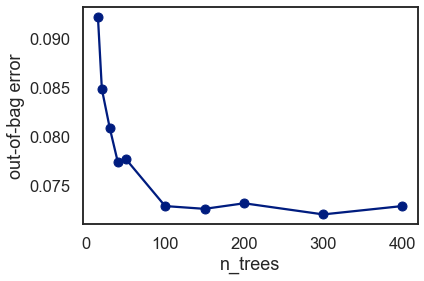

In [49]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

## Question 4

* Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
* Compare the out-of-bag errors for the two different types of models.

In [50]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

,oob
n_trees,
15.0,0.099714
20.0,0.097143
30.0,0.090000
40.0,0.086571
50.0,0.082286
100.0,0.078000
150.0,0.082286
200.0,0.081143
300.0,0.080571


In [51]:
## Combining two dfs for plot
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
15.0,0.092286,0.099714
20.0,0.084857,0.097143
30.0,0.080857,0.090000
40.0,0.077429,0.086571
50.0,0.077714,0.082286
100.0,0.072857,0.078000
150.0,0.072571,0.082286
200.0,0.073143,0.081143
300.0,0.072000,0.080571


The random forest model performs consistently better than the extra randomized trees.

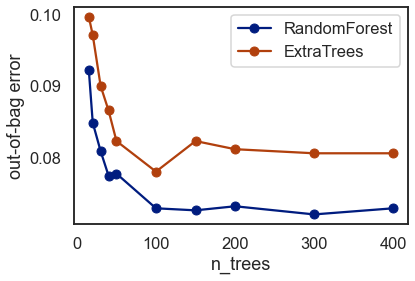

In [52]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag error');

## Question 5

* Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set. 
* Given the distribution of the predicted class, which metric is most important? Which could be deceiving?

In [53]:
# Random forest with 100 estimators
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.932 (vs 0.85 for random guessing).

In [54]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

       False       0.93      0.99      0.96      1288
        True       0.94      0.55      0.70       212

    accuracy                           0.93      1500
   macro avg       0.94      0.77      0.83      1500
weighted avg       0.93      0.93      0.92      1500

   accuracy  precision    recall        f1       auc
0     0.932   0.943548  0.551887  0.696429  0.773226


## Question 6

* Print or visualize the confusion matrix.
* Plot the ROC-AUC and precision-recall curves.
* Plot the feature importances.

Text(0.5, 4.5, 'Prediction')

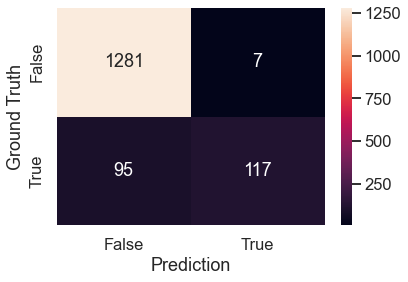

In [55]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Ground Truth');
ax.set_xlabel('Prediction')

The ROC-AUC and precision-recall curves.

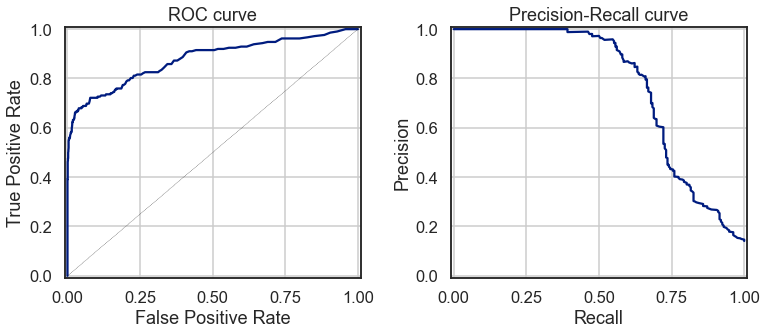

In [56]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(X_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

The feature importances. Total daily cost is the biggest predictor of customer churn.

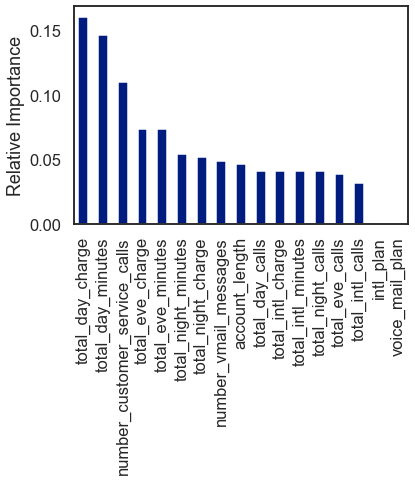

In [57]:
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance');


## <span style="color:red">*Analysis:*</span>
- As expected, when analyzing the two methods used—RandomForest and ExtraRandomForest—for data classification, it is evident that RandomForest achieved a lower error rate than ExtraRandomForest, which aligns with expectations. The error for RandomForest stabilized around 150 trees, meaning that even with a significantly larger number of samples, the error rate would not decrease further. However, RandomForest faced challenges in identifying true positive values (True), as the number of false positives was quite similar to the number of true positives.

- Examining the AUC curve, it becomes clear that while the system struggled to identify true positive values, it demonstrated excellent precision in identifying false negatives, as the AUC curve is close to 1. Furthermore, the Precision-Recall curve reveals that the system maintained high precision across most recall values, which is a positive aspect for this particular problem

- Analyzing the feature importance chart, it is notable that the feature total_day_charge had the most significant impact on data classification. This result is logical since a high charge is likely associated with customer dissatisfaction with the service

- Finally, when comparing the best models from each approach—RandomForest for Bagging and GridSearch with GradientBooster for Boosting—it is evident that the Boosting model delivered a competitive result, achieving an accuracy of 95% compared to 93% for Bagging. Moreover, the Boosting model encountered less difficulty in identifying true positive values, suggesting that it generalized the data more effectively